## What is Image Segmentation?¶
Image segmentation is a technique that involves dividing an image into meaningful and distinct regions or segments. Image segmentation helps to recognize and distinguish different objects or areas within an image by assigning a label to each pixel in the image, grouping similar pixels together. This helps in analyzing the contents of an image more effectively.

For example, if you have a picture of a cat and a dog, segmentation algorithms would learn to understand where the cat is and where the dog is by labeling the pixels that belong to each of them.

Image segmentation is used in various applications, such as object detection, medical image analysis, autonomous vehicles, and more. For instance, in autonomous vehicles, segmentation can help identify the road, pedestrians, and other vehicles.

In [1]:
# Install segmentation models package
!pip install segmentation-models-pytorch -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.8 MB/s eta 0:00:00


## Download Dataset¶
I will be using an open source dataset for this task which is available on GitHub. The dataset contains images of humans in different environments and settings and their corresponding masks. The masks can be thought of as the outline of the humans/objects in the image and helps to identify their positions in the image separating them from the background.

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 32.46 MiB/s, done.
Resolving deltas: 100% (3/3), done.


## Import libraries

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import cv2

from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Setup Configurations¶
In this step I would define the different paths, hyperparameters, models and weights which I will be using later in the notebook.

In [4]:
# Define path variables
TRAIN_DATA_PATH = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/working'

# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 10        # number of epochs
LR = 0.001         # Learning rate
IMG_SIZE = 320     # Size of image
BATCH_SIZE = 32    # Batch size

# Define pretrained encoder model and weights
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

## Load Data

In [5]:
df = pd.read_csv(TRAIN_DATA_PATH)
print(df.shape)
df.head()

(290, 2)


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


## Explore the Data

In [6]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]

def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE) / 255.0

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')

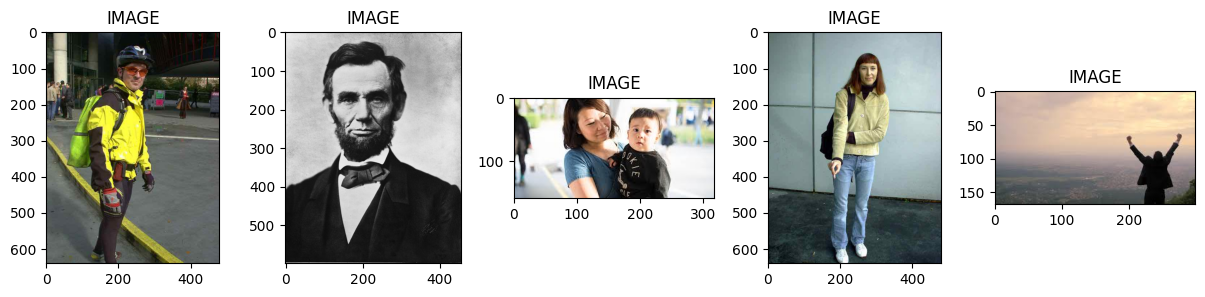

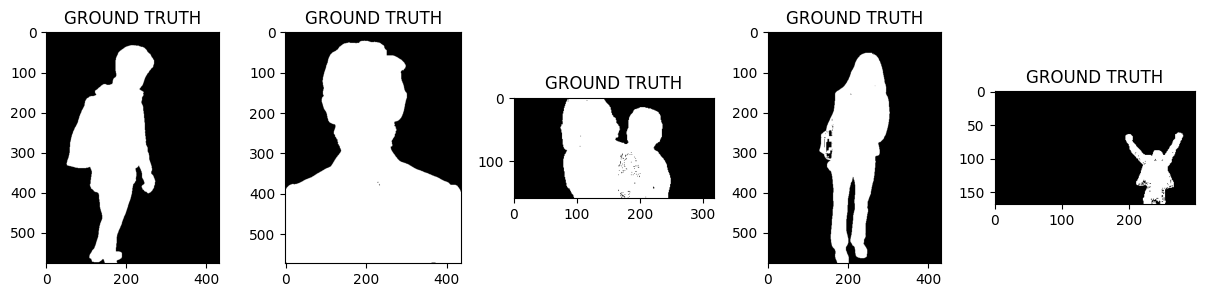

In [7]:
generate_sample_images(sample)
generate_sample_masks(sample)

## Split the Data¶
Let's split our data into training and validation sets before training the model.

In [8]:
# Split data in separate train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=57)

## Data Augmentation¶
Data augmentation is a set of techniques commonly used in deep learning tasks such as image classification. It helps to artificially increase the amount of data by generating new data points from existing data that helps in increasing the performance of the model and reduce overfitting.

In [9]:
import albumentations as A

In [10]:
# Define the augmentations
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),      # Horizontal Flip with 0.5 probability
        A.VerticalFlip(p=0.5)         # Vertical Flip with 0.5 probability
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

## Processing the Dataset

In [11]:
from torch.utils.data import Dataset

# Create a custom dataset class
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.images
        mask = sample.masks

        # Read images and masks
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        # print(f"Shapes of images before augmentation: {image.shape}")
        # print(f"Shapes of masks before augmentation: {mask.shape}")

        # Apply augmentations
        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # print(f"\nShapes of images after augmentation: {image.shape}")
        # print(f"Shapes of masks after augmentation: {mask.shape}")

        # Transpose image dimensions in pytorch format
        # (H,W,C) -> (C,H,W)
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        # Normalize the images and masks
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [12]:
# Processed train and validation sets
train_data = SegmentationDataset(train_df, get_train_augs())
val_data = SegmentationDataset(val_df, get_val_augs())

In [13]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 232
Size of Validset : 58


Let's see a sample image and mask pair from our new processed data.

In [14]:
def processed_image(idx):
    image, mask = train_data[idx]

    plt.subplot(1,2,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title("IMAGE");

    plt.subplot(1,2,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title("GROUND TRUTH");
    plt.show()

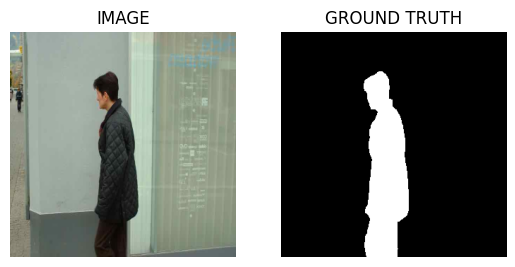

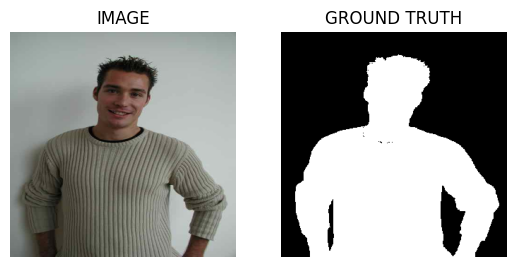

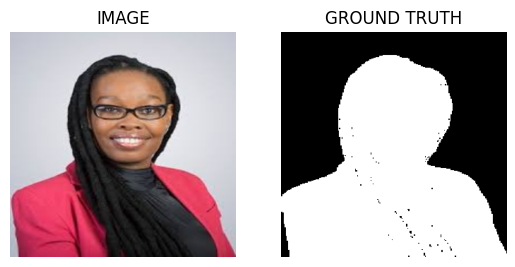

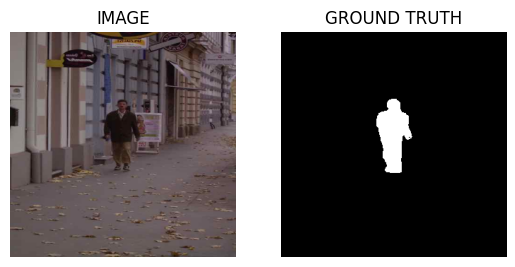

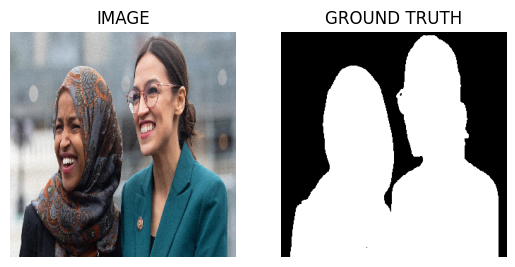

In [15]:
for i in np.random.randint(0, len(train_data), 5):
    processed_image(i)

## Load dataset into batches¶
In this section I load the datasets into batches using the DataLoader class. The batch size was defined earlier with all the other hyperparameters. It can be changed as per the needs. I have set it to 32. The general practice is to set it in powers of 2.

In [16]:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 8
Total number of batches in Val Loader: 2


In [17]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([32, 3, 320, 320])
Size of one batch of masks: torch.Size([32, 1, 320, 320])


## Create Segmentation Model¶
There are many CNN model architectures present in the pytorch's segmentation models documentation that can be used but for this project I will use Unet++ architecture. Unet++ is a fully convolutional neural network for image semantic segmentation. It consists of encoder and decoder parts connected with skip connections. The encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation masks. It uses concatenation for fusing decoder blocks with skip connections.

I will now create the Segmentation model using the Unet++ architecture. The parameters used for the model are:

1. Efficient Net is used as the encoder model
2. Weights used are of Imagenet
3. Input channels are 3 due to RGB images
In the forward method I defined the loss functions. DiceLoss and Binary Cross Entropy are used as loss functions for this task.

Dice loss is a metric commonly used to evaluate the performance of machine learning models in image segmentation tasks. It is a measure of the dissimilarity between the predicted segmentation (mask) and the true segmentation of an image.

In [18]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [19]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [20]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 143MB/s]


## Create Train and Validation Function

In [21]:
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [22]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

## Model Training¶
Before training the model make sure that your GPU is running because it would take eternity to train the model on a CPU.

In [23]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training and evaluation loop
best_val_loss = 1e9

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


MODEL SAVED
 Epoch 1 Train Loss 1.1619750782847404 Val Loss 4.1688971519470215


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


MODEL SAVED
 Epoch 2 Train Loss 0.7380464747548103 Val Loss 0.5665146112442017


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


MODEL SAVED
 Epoch 3 Train Loss 0.5324527285993099 Val Loss 0.3602539598941803


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


MODEL SAVED
 Epoch 4 Train Loss 0.4090983308851719 Val Loss 0.3405781388282776


100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


MODEL SAVED
 Epoch 5 Train Loss 0.32203624211251736 Val Loss 0.32014450430870056


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


MODEL SAVED
 Epoch 6 Train Loss 0.2673248965293169 Val Loss 0.2944492995738983


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


MODEL SAVED
 Epoch 7 Train Loss 0.2395662683993578 Val Loss 0.2302774041891098


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


MODEL SAVED
 Epoch 8 Train Loss 0.22403056733310223 Val Loss 0.20592457056045532


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


 Epoch 9 Train Loss 0.17519019730389118 Val Loss 0.22997982800006866


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

MODEL SAVED
 Epoch 10 Train Loss 0.18619678542017937 Val Loss 0.1974622905254364


## Inference

In [24]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# Function to output the prediction mask
def make_inference(idx):
    image, mask = val_data[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

    # Predicted mask
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0

    return image, mask, pred_mask

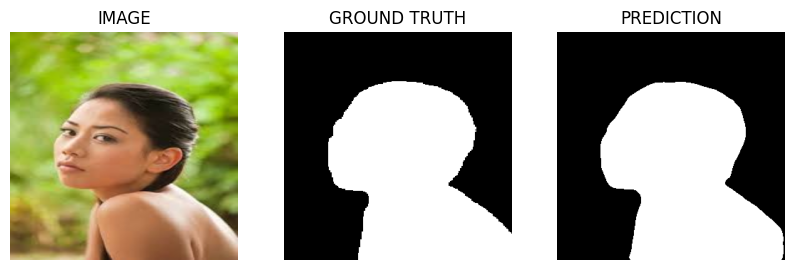

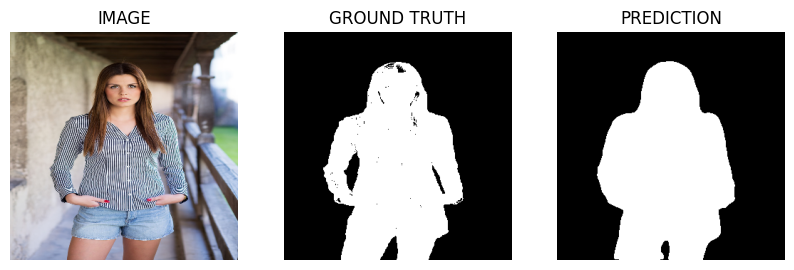

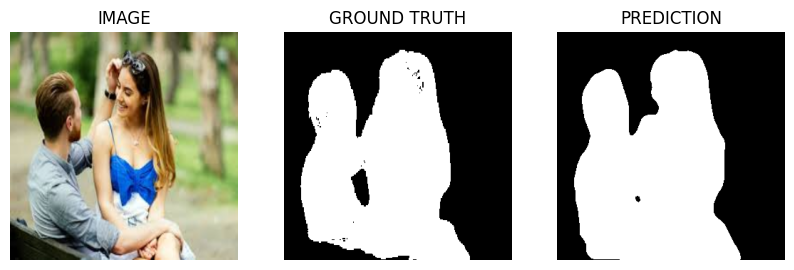

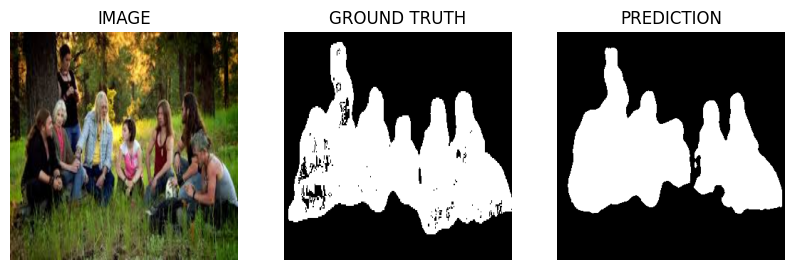

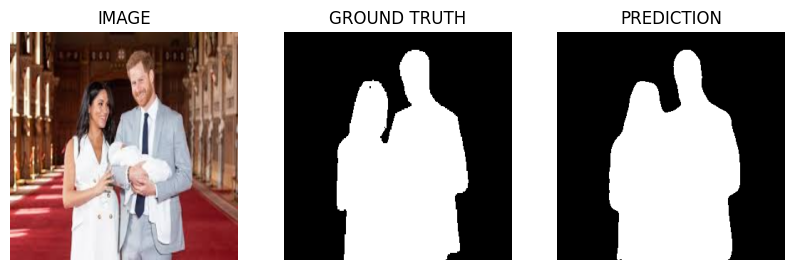

In [25]:
# Compare predictions with original
for i in np.random.randint(0, len(val_data), 5):
    image, mask, pred_mask = make_inference(i)

    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');